In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import json
import itertools

In [2]:
flex_dir = "dynamic/"
minimal_dir = "min/"
maximal_dir = "max/"

In [3]:
learning_steps = 1024000 * 2
n_steps_value = 2048 * 8
number_of_rollouts = learning_steps / n_steps_value

In [4]:
def string_to_list(string):
    string = string[1:-1]
    string = string.replace(" ", "")
    res = string.split(",")
    return [float(x) for x in res]    

def string_to_list_of_lists(string):
    res = []
    string = string[1:-1]
    string = string.replace(" ", "")
    outer_list = string.split("],")
    for inner_list in outer_list:
        tmp_str = inner_list+"]"
        res.append(tmp_str)
    res[-1] = res[-1][:-1]
    return [_list.strip("[]").split(",") for _list in res]

def combine_lists(attribute_list, folder_name):
    res = []
    for file in attribute_list:
        with open(folder_name+file, "r") as infile:
            data = infile.read()
            res.append(string_to_list(data))
    return res

def combine_lists_distribution(list_of_text_files, folder_name):
    res = []
    for file in list_of_text_files:
        with open(folder_name+file, "r") as infile:
            data = infile.read()
            res.append(string_to_list_of_lists(data))
    return res

def mean_min_max(list_of_lists):
    _mean = []
    _min = []
    _max = []
    for elements in zip(*list_of_lists):
        _min.append(min(elements))
        _max.append(max(elements))
        _mean.append(sum(elements)/len(elements))
    return _mean, _min, _max  

def mean_min_max_distribution(list_of_lists):
    _mean = []
    _min = []
    _max = []
    for elements in itertools.zip_longest(*list_of_lists, fillvalue=0):
        float_elements = [float(x) for x in elements]
        _min.append(min(float_elements))
        _max.append(max(float_elements))
        _mean.append(sum(float_elements)/len(float_elements))
    return _mean, _min, _max

In [5]:
def plot_in_between(mean_min_max_list):
    _x = list(range(len(mean_min_max_list[0])))
    _y_mean = mean_min_max_list[0]
    _y_min = mean_min_max_list[1]
    _y_max = mean_min_max_list[2]
    plt.plot(_x, _y_mean)
    plt.fill_between(_x, _y_min, _y_max, alpha=0.3)
    plt.show()

def plot_by_metric(metric):
    metric_list_flex = [path for path in os.listdir(flex_dir) if metric in path]
    metric_list_min = [path for path in os.listdir(minimal_dir) if metric in path]
    metric_list_max = [path for path in os.listdir(maximal_dir) if metric in path]
    
    _y_flex_mean, _y_flex_min, _y_flex_max = mean_min_max(combine_lists(metric_list_flex, flex_dir))
    _y_min_mean, _y_min_min, _y_min_max = mean_min_max(combine_lists(metric_list_min, minimal_dir))
    _y_max_mean, _y_max_min, _y_max_max = mean_min_max(combine_lists(metric_list_max, maximal_dir))
    _x = list(range(len(_y_min_max)))
    
    #plt.plot(_x, _y_flex_mean, color="blue")
    plt.plot(_x, _y_min_mean, color="green")
   # plt.plot(_x, _y_max_mean, color="red")
    plt.grid()
    learning_step_ticks = [i*n_steps_value for i in _x]
    _x_ticks = np.arange(min(learning_step_ticks), max(learning_step_ticks)+1, n_steps_value)
    plt.xticks(_x[::15], _x_ticks[::15], rotation=45)
    
    #plt.fill_between(_x, _y_flex_min, _y_flex_max, alpha=0.3, color="blue", label="dynamic")
    plt.fill_between(_x, _y_min_min, _y_min_max, alpha=0.3, color="green", label="min")
    #plt.fill_between(_x, _y_max_min, _y_max_max, alpha=0.3, color="red", label="max")
    plt.legend(loc="best")
    plt.title(metric)
    plt.autoscale()
    plt.savefig(f"{metric}.png", dpi=300, facecolor='white', edgecolor='none')
    plt.show()
    
    
def plot_trajectory(last_ten_trajectories):
    for run in last_ten_trajectories:
        _xs = []
        _ys = []
        for coordinate in run[:-1]:
            _xs.append(coordinate[0])
            _ys.append(coordinate[1]-95) # width / 2 - sprite / 2
        plt.plot(_xs, _ys)
    #plt.show()
    
    
def plot_distribution(last_ten_distributions):
    for run in last_ten_distributions:
        run = sum(run, [])
        _xs = list(range(len(run)))
        _ys = []
        
        for coordinate in run:
            _ys.append(coordinate)
        plt.plot(_xs, _ys, color='g')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()
    
    
def plot_complete_distribution(distribution):
    distri_list_flex = [path for path in os.listdir(flex_dir) if distribution in path]
    distri_list_min = [path for path in os.listdir(minimal_dir) if distribution in path]
    distri_list_max = [path for path in os.listdir(maximal_dir) if distribution in path]

    _flex_distris_outer = combine_lists_distribution(distri_list_flex, flex_dir)
    _flex_distri_combined = list(itertools.chain.from_iterable(_flex_distris_outer))

    _min_distris_outer = combine_lists_distribution(distri_list_min, minimal_dir)
    _min_distri_combined = list(itertools.chain.from_iterable(_min_distris_outer))

    _max_distris_outer = combine_lists_distribution(distri_list_max, maximal_dir)
    _max_distri_combined = list(itertools.chain.from_iterable(_max_distris_outer))

    combined_lists = _flex_distri_combined + _min_distri_combined + _max_distri_combined
    _y_combined_mean, _y_combined_min, _y_combined_max = mean_min_max_distribution(combined_lists)

    _x = list(range(len(_y_combined_mean)))

    plt.plot(_x, _y_combined_mean, color="blue")
    plt.fill_between(_x, _y_combined_min, _y_combined_max, alpha=0.3, color="blue", label="dynamic")
    plt.grid()
    plt.savefig(f"distribution_average.png", dpi=300, facecolor='white', edgecolor='none')
    plt.show()
    
def align_yaxis(ax1, ax2):
    y_lims = np.array([ax.get_ylim() for ax in [ax1, ax2]])

    # force 0 to appear on both axes, comment if don't need
    y_lims[:, 0] = y_lims[:, 0].clip(None, 0)
    y_lims[:, 1] = y_lims[:, 1].clip(0, None)

    # normalize both axes
    y_mags = (y_lims[:,1] - y_lims[:,0]).reshape(len(y_lims),1)
    y_lims_normalized = y_lims / y_mags

    # find combined range
    y_new_lims_normalized = np.array([np.min(y_lims_normalized), np.max(y_lims_normalized)])

    # denormalize combined range to get new axes
    new_lim1, new_lim2 = y_new_lims_normalized * y_mags
    ax1.set_ylim(new_lim1)
    ax2.set_ylim(new_lim2)
    
    
def combine_distri_trajectory(trajectory, distribution):

    t_xs = []
    t_ys = []
    for coordinate in trajectory[0][:-1]:
        #t_xs.append(coordinate[0])
        t_ys.append(coordinate[1])
    t_xs = [i for i in range(len(trajectory[0])-1)]
    
    fig, ax1 = plt.subplots()
    plt.grid()
    plt.axhline(y=0, color='r', linestyle='--')
    plt.axhline(y=80, color='brown', linestyle='dotted')
    plt.axhline(y=-80, color='brown', linestyle='dotted')
    
    color = 'tab:blue'
    ax1.set_xlabel('steps')
    ax1.set_ylabel('y_coords', color=color)
    ax1.plot(t_xs, t_ys)
    ax1.tick_params(axis='y', labelcolor=color)
    
    
    d_xs = [i for i in range(len(distribution[0]))]
    d_ys = []   
    for coordinate in distribution[0]:
        d_ys.append(coordinate)
    
    
    ax2 =ax1.twinx()
    
    color = 'tab:green'
    ax2.set_ylabel('wind', color=color)
    ax2.plot(d_xs, d_ys, color=color, alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    
    
    align_yaxis(ax1, ax2)
    fig.tight_layout()
    plt.savefig("distribution_trajectory_combination.png",facecolor='white', dpi=300, transparent=False)
    plt.show()
    
                 

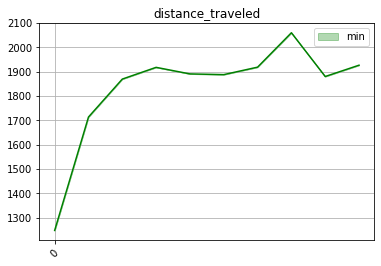

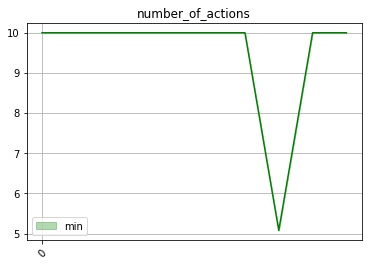

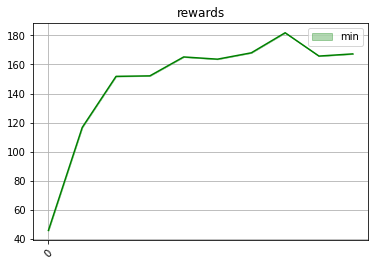

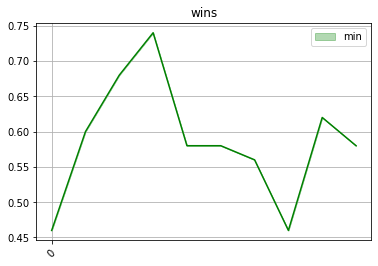

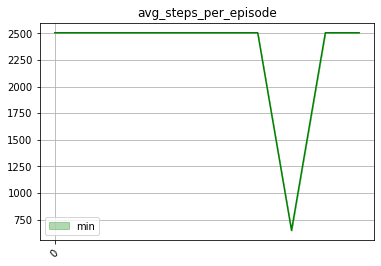

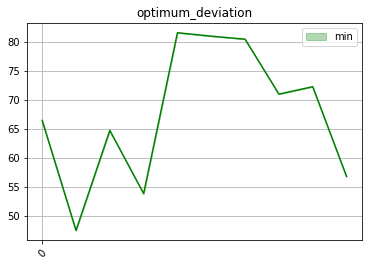

In [6]:
#plot_by_metric("commitment")
plot_by_metric("distance_traveled")
plot_by_metric("number_of_actions") #todo this metrics values are most likely wrong
plot_by_metric("rewards")
plot_by_metric("wins")
plot_by_metric("avg_steps_per_episode")
plot_by_metric("optimum_deviation")
#plot_complete_distribution("complete_distribution")

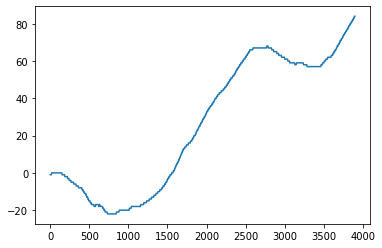

In [7]:
t="[[[5, 94], [10, 94], [15, 94], [20, 95], [25, 95], [30, 95], [35, 95], [40, 95], [45, 95], [50, 95], [55, 95], [60, 95], [65, 95], [70, 95], [75, 95], [80, 95], [85, 95], [90, 95], [95, 95], [100, 95], [105, 95], [110, 95], [115, 95], [120, 95], [125, 95], [130, 95], [135, 95], [140, 95], [145, 95], [150, 95], [155, 94], [160, 94], [165, 94], [170, 94], [175, 94], [180, 94], [185, 94], [190, 93], [195, 93], [200, 93], [205, 93], [210, 93], [215, 93], [220, 93], [225, 92], [230, 92], [235, 92], [240, 92], [245, 91], [250, 91], [255, 91], [260, 91], [265, 91], [270, 90], [275, 90], [280, 90], [285, 90], [290, 90], [295, 90], [300, 90], [305, 89], [310, 89], [315, 89], [320, 89], [325, 89], [330, 89], [335, 88], [340, 88], [345, 88], [350, 88], [355, 88], [360, 88], [365, 87], [370, 87], [375, 87], [380, 87], [385, 87], [390, 87], [395, 87], [400, 87], [405, 87], [410, 86], [415, 86], [420, 86], [425, 85], [430, 85], [435, 85], [440, 84], [445, 84], [450, 84], [455, 84], [460, 83], [465, 83], [470, 82], [475, 82], [480, 82], [485, 81], [490, 81], [495, 80], [500, 80], [505, 80], [510, 80], [515, 79], [520, 79], [525, 79], [530, 78], [535, 78], [540, 78], [545, 78], [550, 78], [555, 78], [560, 78], [565, 77], [570, 77], [575, 77], [580, 77], [585, 78], [590, 78], [595, 78], [600, 78], [605, 78], [610, 78], [615, 78], [620, 78], [625, 77], [630, 78], [635, 78], [640, 77], [645, 77], [650, 77], [655, 77], [660, 77], [665, 77], [670, 77], [675, 76], [680, 76], [685, 76], [690, 75], [695, 75], [700, 75], [705, 74], [710, 74], [715, 74], [720, 74], [725, 74], [730, 74], [735, 73], [740, 73], [745, 73], [750, 73], [755, 73], [760, 73], [765, 73], [770, 73], [775, 73], [780, 73], [785, 73], [790, 73], [795, 73], [800, 73], [805, 73], [810, 73], [815, 73], [820, 73], [825, 73], [830, 73], [835, 73], [840, 73], [845, 73], [850, 74], [855, 74], [860, 74], [865, 74], [870, 74], [875, 74], [880, 74], [885, 75], [890, 75], [895, 75], [900, 75], [905, 75], [910, 75], [915, 75], [920, 75], [925, 75], [930, 75], [935, 75], [940, 75], [945, 75], [950, 75], [955, 75], [960, 75], [965, 75], [970, 75], [975, 75], [980, 75], [985, 75], [990, 75], [995, 75], [1000, 75], [1005, 75], [1010, 75], [1015, 76], [1020, 76], [1025, 76], [1030, 76], [1035, 76], [1040, 77], [1045, 77], [1050, 77], [1055, 77], [1060, 77], [1065, 77], [1070, 77], [1075, 77], [1080, 77], [1085, 77], [1090, 77], [1095, 77], [1100, 77], [1105, 77], [1110, 77], [1115, 77], [1120, 77], [1125, 77], [1130, 77], [1135, 77], [1140, 77], [1145, 77], [1150, 77], [1155, 77], [1160, 78], [1165, 78], [1170, 78], [1175, 78], [1180, 78], [1185, 78], [1190, 78], [1195, 78], [1200, 79], [1205, 79], [1210, 79], [1215, 79], [1220, 79], [1225, 79], [1230, 79], [1235, 80], [1240, 80], [1245, 80], [1250, 80], [1255, 80], [1260, 80], [1265, 80], [1270, 81], [1275, 81], [1280, 81], [1285, 81], [1290, 81], [1295, 81], [1300, 82], [1305, 82], [1310, 82], [1315, 82], [1320, 82], [1325, 82], [1330, 83], [1335, 83], [1340, 83], [1345, 83], [1350, 83], [1355, 84], [1360, 84], [1365, 84], [1370, 84], [1375, 84], [1380, 85], [1385, 85], [1390, 85], [1395, 85], [1400, 85], [1405, 86], [1410, 86], [1415, 86], [1420, 86], [1425, 86], [1430, 87], [1435, 87], [1440, 87], [1445, 88], [1450, 88], [1455, 88], [1460, 88], [1465, 89], [1470, 89], [1475, 89], [1480, 90], [1485, 90], [1490, 90], [1495, 91], [1500, 91], [1505, 92], [1510, 92], [1515, 92], [1520, 93], [1525, 93], [1530, 93], [1535, 94], [1540, 94], [1545, 94], [1550, 94], [1555, 95], [1560, 95], [1565, 95], [1570, 95], [1575, 96], [1580, 96], [1585, 96], [1590, 97], [1595, 97], [1600, 98], [1605, 98], [1610, 99], [1615, 99], [1620, 100], [1625, 100], [1630, 100], [1635, 101], [1640, 101], [1645, 102], [1650, 102], [1655, 103], [1660, 103], [1665, 104], [1670, 104], [1675, 105], [1680, 105], [1685, 106], [1690, 106], [1695, 107], [1700, 107], [1705, 108], [1710, 108], [1715, 108], [1720, 108], [1725, 109], [1730, 109], [1735, 109], [1740, 109], [1745, 110], [1750, 110], [1755, 110], [1760, 110], [1765, 110], [1770, 111], [1775, 111], [1780, 111], [1785, 111], [1790, 111], [1795, 112], [1800, 112], [1805, 112], [1810, 112], [1815, 113], [1820, 113], [1825, 113], [1830, 114], [1835, 114], [1840, 115], [1845, 115], [1850, 115], [1855, 115], [1860, 116], [1865, 116], [1870, 117], [1875, 117], [1880, 118], [1885, 118], [1890, 118], [1895, 119], [1900, 119], [1905, 120], [1910, 120], [1915, 120], [1920, 121], [1925, 121], [1930, 122], [1935, 122], [1940, 122], [1945, 123], [1950, 123], [1955, 124], [1960, 124], [1965, 124], [1970, 125], [1975, 125], [1980, 125], [1985, 126], [1990, 126], [1995, 127], [2000, 127], [2005, 128], [2010, 128], [2015, 128], [2020, 129], [2025, 129], [2030, 129], [2035, 130], [2040, 130], [2045, 130], [2050, 131], [2055, 131], [2060, 131], [2065, 131], [2070, 132], [2075, 132], [2080, 132], [2085, 133], [2090, 133], [2095, 133], [2100, 134], [2105, 134], [2110, 135], [2115, 135], [2120, 135], [2125, 135], [2130, 136], [2135, 136], [2140, 136], [2145, 137], [2150, 137], [2155, 137], [2160, 137], [2165, 138], [2170, 138], [2175, 138], [2180, 138], [2185, 138], [2190, 139], [2195, 139], [2200, 139], [2205, 139], [2210, 139], [2215, 140], [2220, 140], [2225, 140], [2230, 140], [2235, 141], [2240, 141], [2245, 141], [2250, 141], [2255, 142], [2260, 142], [2265, 142], [2270, 143], [2275, 143], [2280, 143], [2285, 144], [2290, 144], [2295, 144], [2300, 145], [2305, 145], [2310, 145], [2315, 146], [2320, 146], [2325, 146], [2330, 146], [2335, 147], [2340, 147], [2345, 147], [2350, 147], [2355, 148], [2360, 148], [2365, 148], [2370, 149], [2375, 149], [2380, 150], [2385, 150], [2390, 150], [2395, 151], [2400, 151], [2405, 151], [2410, 152], [2415, 152], [2420, 152], [2425, 153], [2430, 153], [2435, 153], [2440, 154], [2445, 154], [2450, 154], [2455, 154], [2460, 155], [2465, 155], [2470, 155], [2475, 156], [2480, 156], [2485, 156], [2490, 156], [2495, 157], [2500, 157], [2505, 157], [2510, 158], [2515, 158], [2520, 158], [2525, 159], [2530, 159], [2535, 159], [2540, 160], [2545, 160], [2550, 160], [2555, 161], [2560, 161], [2565, 161], [2570, 161], [2575, 161], [2580, 161], [2585, 161], [2590, 161], [2595, 162], [2600, 162], [2605, 162], [2610, 162], [2615, 162], [2620, 162], [2625, 162], [2630, 162], [2635, 162], [2640, 162], [2645, 162], [2650, 162], [2655, 162], [2660, 162], [2665, 162], [2670, 162], [2675, 162], [2680, 162], [2685, 162], [2690, 162], [2695, 162], [2700, 162], [2705, 162], [2710, 162], [2715, 162], [2720, 162], [2725, 162], [2730, 162], [2735, 162], [2740, 162], [2745, 162], [2750, 162], [2755, 162], [2760, 162], [2765, 162], [2770, 163], [2775, 163], [2780, 163], [2785, 163], [2790, 162], [2795, 162], [2800, 162], [2805, 162], [2810, 162], [2815, 162], [2820, 162], [2825, 162], [2830, 162], [2835, 161], [2840, 161], [2845, 161], [2850, 161], [2855, 161], [2860, 160], [2865, 160], [2870, 160], [2875, 160], [2880, 160], [2885, 160], [2890, 160], [2895, 160], [2900, 159], [2905, 159], [2910, 159], [2915, 159], [2920, 159], [2925, 158], [2930, 158], [2935, 158], [2940, 158], [2945, 158], [2950, 158], [2955, 158], [2960, 157], [2965, 157], [2970, 157], [2975, 157], [2980, 157], [2985, 157], [2990, 157], [2995, 157], [3000, 156], [3005, 156], [3010, 156], [3015, 156], [3020, 156], [3025, 156], [3030, 156], [3035, 156], [3040, 155], [3045, 155], [3050, 155], [3055, 155], [3060, 155], [3065, 154], [3070, 154], [3075, 154], [3080, 154], [3085, 154], [3090, 154], [3095, 154], [3100, 154], [3105, 154], [3110, 154], [3115, 154], [3120, 154], [3125, 154], [3130, 153], [3135, 153], [3140, 153], [3145, 153], [3150, 154], [3155, 154], [3160, 154], [3165, 154], [3170, 154], [3175, 154], [3180, 154], [3185, 154], [3190, 154], [3195, 154], [3200, 154], [3205, 154], [3210, 154], [3215, 154], [3220, 154], [3225, 154], [3230, 154], [3235, 154], [3240, 153], [3245, 153], [3250, 153], [3255, 153], [3260, 153], [3265, 153], [3270, 153], [3275, 153], [3280, 153], [3285, 152], [3290, 152], [3295, 152], [3300, 152], [3305, 152], [3310, 152], [3315, 152], [3320, 152], [3325, 152], [3330, 152], [3335, 152], [3340, 152], [3345, 152], [3350, 152], [3355, 152], [3360, 152], [3365, 152], [3370, 152], [3375, 152], [3380, 152], [3385, 152], [3390, 152], [3395, 152], [3400, 152], [3405, 152], [3410, 152], [3415, 152], [3420, 152], [3425, 152], [3430, 152], [3435, 152], [3440, 152], [3445, 152], [3450, 152], [3455, 152], [3460, 152], [3465, 153], [3470, 153], [3475, 153], [3480, 153], [3485, 154], [3490, 154], [3495, 154], [3500, 154], [3505, 155], [3510, 155], [3515, 155], [3520, 155], [3525, 156], [3530, 156], [3535, 156], [3540, 156], [3545, 156], [3550, 157], [3555, 157], [3560, 157], [3565, 157], [3570, 157], [3575, 157], [3580, 157], [3585, 157], [3590, 157], [3595, 158], [3600, 158], [3605, 158], [3610, 158], [3615, 159], [3620, 159], [3625, 159], [3630, 160], [3635, 160], [3640, 160], [3645, 161], [3650, 161], [3655, 161], [3660, 162], [3665, 162], [3670, 163], [3675, 163], [3680, 163], [3685, 164], [3690, 164], [3695, 164], [3700, 165], [3705, 165], [3710, 166], [3715, 166], [3720, 166], [3725, 167], [3730, 167], [3735, 167], [3740, 168], [3745, 168], [3750, 169], [3755, 169], [3760, 169], [3765, 170], [3770, 170], [3775, 170], [3780, 171], [3785, 171], [3790, 171], [3795, 172], [3800, 172], [3805, 172], [3810, 173], [3815, 173], [3820, 174], [3825, 174], [3830, 174], [3835, 175], [3840, 175], [3845, 175], [3850, 176], [3855, 176], [3860, 176], [3865, 177], [3870, 177], [3875, 177], [3880, 178], [3885, 178], [3890, 179], [3895, 179], [0, 95]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]]]"
plot_trajectory(json.loads(t))

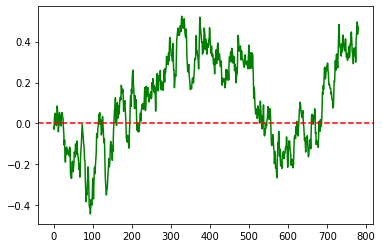

In [8]:
d="[[[-0.01882549636410929], [-0.028504787210063946], [0.030144437314632462], [0.03841375066241195], [0.04996678611994687], [0.03584831344550385], [-0.007090599947944025], [-0.01072423791806276], [0.021917336964286063], [0.08533501957384562], [0.06180850202631444], [0.03026399336362346], [-0.041276857664770045], [-0.014808841458091058], [-0.006562283807942994], [0.05225062725702015], [0.030877692787949135], [0.017425861482021958], [0.03665787777383958], [-0.012261904509456613], [0.033477741019084725], [0.0529479546694287], [0.049150949526000284], [0.030178806880257394], [0.024246988374365917], [-0.02420658371201096], [-0.05153279156576342], [-0.10685507749613324], [-0.08047229340700505], [-0.16580419190124607], [-0.18884997378378207], [-0.14937887166959085], [-0.1355029203437748], [-0.1155282329903382], [-0.15103900454886185], [-0.12324073660022337], [-0.12869864938694808], [-0.13736378564199803], [-0.14438125654781647], [-0.1457275449904416], [-0.1585777623499025], [-0.1156171649881329], [-0.1342585623131229], [-0.2464588576867543], [-0.2595691463226575], [-0.26759121293998894], [-0.2684897411916816], [-0.19770926264205585], [-0.18447708467705848], [-0.20834864329496797], [-0.23596268824422906], [-0.21150687017609882], [-0.18932941172036544], [-0.13991122098667208], [-0.16491325405087762], [-0.14810216628896544], [-0.09993656322116398], [-0.12229058793293747], [-0.15121463047553507], [-0.12200633805127367], [-0.0856694765156139], [-0.14359232189810997], [-0.15773971129894518], [-0.16682221456512109], [-0.1962844497811347], [-0.22568819644323176], [-0.19640644155295334], [-0.2624129610914233], [-0.21842451733686918], [-0.15505936462050096], [-0.12797110339699813], [-0.09347599697150369], [-0.047631228393072614], [-0.004453582636590528], [-0.030933581326065752], [-0.06390256453986874], [-0.08697192030706209], [-0.10387815637104428], [-0.11859125859355517], [-0.1772186053377282], [-0.1804318703507274], [-0.2732948071050555], [-0.3362143332273524], [-0.3826154399599856], [-0.3343523683545925], [-0.3501847363551397], [-0.31319916711502666], [-0.26704560767189395], [-0.21220008574348925], [-0.24731754817513657], [-0.33401873939679316], [-0.40011680343065353], [-0.4108971799620715], [-0.41423742049700174], [-0.44204954897589793], [-0.410832111724339], [-0.3715009001985751], [-0.3989979993011471], [-0.39857580563250644], [-0.3417141064600376], [-0.26768593889233205], [-0.30110137827078187], [-0.36892964147412266], [-0.2942524490740951], [-0.21966701870752017], [-0.21300395412920534], [-0.24528379697667474], [-0.19887934229100573], [-0.17441404021538784], [-0.13984204474523235], [-0.05028354456845732], [-0.05332902449967222], [-0.06981023553591309], [-0.02390753914146785], [-0.017607887376908892], [0.013715788112372292], [0.045814936194654377], [0.03320731050566782], [0.0519855519757028], [-0.004602744553683397], [0.019252888051594485], [0.011320914837012185], [-0.056400001699016516], [-0.04452491912551068], [-0.020249191622737937], [0.03380906336606561], [0.0034941425927349154], [-0.041301152584347224], [-0.07448103209311996], [-0.09402660009573703], [-0.07616682360486336], [-0.17641262884549203], [-0.255955865158025], [-0.29549106253311047], [-0.3299412153954503], [-0.3497089988666118], [-0.32414447089943293], [-0.31626841176705384], [-0.2889319608078994], [-0.24799132075295158], [-0.22251443919016306], [-0.17236636248207815], [-0.2126284015207882], [-0.20906674809002448], [-0.17339819267751147], [-0.11727137022029649], [-0.08772225573730005], [-0.1107177903069927], [-0.13827246059298862], [-0.10592093507096687], [-0.18021358222482003], [-0.12336780202506525], [-0.1348399293318913], [-0.043327513605367116], [-0.0033309236794510713], [0.031537534840688906], [0.0714438322966374], [0.05989139444232013], [0.12529943721961895], [0.004547330895472768], [0.017352251497012], [-0.010149368796082053], [0.08673304750754794], [0.1017689395393786], [0.024278547206975115], [0.07419026859322891], [0.08646683863913113], [0.04525687463832443], [0.06486823164817829], [0.10583194216671235], [0.12567510736327084], [0.12757808051619712], [0.11479245956246335], [0.18642159751382936], [0.17623853766037423], [0.14985378820690748], [0.1493804399089793], [0.1674222686260963], [0.1291107306521693], [0.059658656201015306], [0.07028489456372342], [0.09448554080759979], [0.11136203241562137], [0.07748097847757324], [0.04316593955889418], [0.005524484494545276], [-0.07184001417240644], [-0.06623880321171827], [-0.09077617802172402], [-0.05776638363542145], [-0.06600202652518602], [-0.08075215321568195], [-0.11271819517251425], [-0.12108077290778042], [-0.03183579668304366], [0.0014093980493432648], [0.09493903072486638], [0.13624417478300432], [0.08254263115520005], [0.16629966161971016], [0.14585097403192704], [0.21566737205535152], [0.2453049122343052], [0.26065662175514903], [0.19669865758029978], [0.16986929357033978], [0.1233447354747369], [0.0732759661413723], [0.13619310983138255], [0.08927821102399733], [0.0761312043385742], [0.11602428735316442], [0.03222921814022306], [-0.028500378366848315], [-0.03438234316987579], [0.0011175226915365322], [-0.040815019862503694], [-0.015819260036278492], [-0.04032031663472904], [-0.01550386713131658], [-0.008162031306208153], [0.026331816613285597], [0.05041227288189305], [0.011558688460082456], [0.058755673241933405], [0.07200835019918753], [0.0904382190787089], [0.09416108731024185], [0.07249384262776741], [0.0963215896345472], [0.06872589482986584], [0.08492871679248938], [0.11909088092520467], [0.17548978568832638], [0.14714316360300303], [0.06284025972226946], [0.09471264350016632], [0.18191695857929457], [0.13158965400188843], [0.15805675270570566], [0.1652723597170266], [0.1760517261922975], [0.14714008291926386], [0.11262613512190942], [0.10435535775342068], [0.11902525896322688], [0.14031359893017875], [0.1254239165556927], [0.15437042945500482], [0.12164896023523723], [0.12166840861692982], [0.12932708310037308], [0.2001091624645624], [0.17201359248454626], [0.2191432074744364], [0.18662745572270228], [0.15866828930102883], [0.18575025806513468], [0.14992405180008728], [0.1750780496024537], [0.1421989802691492], [0.06014077297143494], [0.14430526915171582], [0.1926594686135889], [0.22066230301020912], [0.2444164067007785], [0.18731405386719183], [0.15952799936023465], [0.16290228067712004], [0.21253389046132545], [0.23603676404678445], [0.21102146744087616], [0.236451927666964], [0.25882324839077825], [0.16480757004789606], [0.20647355335291276], [0.17260541363445014], [0.18810287529801809], [0.19895045915246015], [0.16171868268691653], [0.1624813247358654], [0.20958125229257643], [0.21304591897005629], [0.26230119399463997], [0.20201021361448826], [0.26748643383687415], [0.2463458447259586], [0.2605400105028691], [0.27614657275463916], [0.32818788204442567], [0.29720501064678484], [0.304372122940924], [0.3066543644512588], [0.2870305600881594], [0.3453406581116994], [0.3042842474005226], [0.36729045085805934], [0.42065297388814865], [0.4050533909799139], [0.37254738359890766], [0.3605940175447166], [0.33043880217216537], [0.3321367025078595], [0.33684006051444737], [0.30447248414525246], [0.3914232362015285], [0.3340628292778468], [0.26009061320168714], [0.2604480433761234], [0.1743291158583879], [0.20014524718478627], [0.2399327086546711], [0.23237796155906723], [0.23096180707772007], [0.3236321568185157], [0.410273699660054], [0.42963341962502094], [0.44851119218023006], [0.46594635098204995], [0.43061701164662936], [0.4311341811509313], [0.4410470594695999], [0.431927738517251], [0.46033368867053726], [0.477089476857082], [0.4706853682205887], [0.4484275798884765], [0.5122871807147011], [0.5237501531579879], [0.4686160245811014], [0.5043675208000821], [0.4890852409615281], [0.4642455447926861], [0.4919521942765317], [0.5115842309424804], [0.48235551251194847], [0.4406406127682719], [0.427761428842197], [0.41912729060258913], [0.4612033151309906], [0.42448895437400846], [0.3310937087358213], [0.28966221536888637], [0.2539010845021048], [0.25196292123823844], [0.2808043306738662], [0.2884189546392195], [0.22998697171881222], [0.21327294098171662], [0.1875378401025274], [0.16533225812344368], [0.1806432013958894], [0.17880369334962176], [0.16974179922249547], [0.19303939837127795], [0.21980024905720838], [0.2228475229111678], [0.20727027071989082], [0.197946904772826], [0.2334775803577885], [0.2586079245532568], [0.31653295294873457], [0.3125182030120956], [0.3129635802402503], [0.37836019650215424], [0.4298883231959901], [0.34357633302183105], [0.354067678582779], [0.3342939719923041], [0.32503022747010973], [0.30326553332963446], [0.26640632978104545], [0.33099160911923814], [0.4218742995135262], [0.518823028133484], [0.48694018419956], [0.465585888539756], [0.44914396409094226], [0.4206786898626296], [0.39582677962700336], [0.3997253603735423], [0.33874330716892254], [0.35256941765154204], [0.34986514191328133], [0.3746556656651566], [0.46637639362574507], [0.4565745657311265], [0.435274936837266], [0.36122821310367925], [0.4124716721005067], [0.3961348701337563], [0.3738197644019305], [0.3383459526767166], [0.36073796022419197], [0.39088007684260373], [0.37831100958476016], [0.3721036705899135], [0.4104991196515424], [0.41268203130586545], [0.46727363337775324], [0.44155034839412866], [0.382926396588023], [0.37866131152226196], [0.3418279517249055], [0.37731896996636016], [0.33919667623099214], [0.32690548337963443], [0.3380282446685324], [0.321583857467856], [0.2894818296955305], [0.2886244690812852], [0.2907322699014633], [0.24230125883642067], [0.3177925803524731], [0.28855573852674427], [0.33471723389404373], [0.3606325394489267], [0.29216372563236526], [0.31601003223543844], [0.3706347653367657], [0.3931978606395685], [0.3855693269565026], [0.31031835908461847], [0.31691362238289555], [0.34118163196802076], [0.3294676126475122], [0.2844433016020255], [0.2774345273598337], [0.28401801912902047], [0.30553580730132224], [0.22638086578682987], [0.18666269965700533], [0.22105943287674076], [0.21877186362724774], [0.21173649789210133], [0.2032110462227506], [0.21917586787642945], [0.2112961445628223], [0.17408847758405696], [0.18803757002084323], [0.19072014331295806], [0.26268085245475914], [0.24410597231197032], [0.26360666668953786], [0.2252662780263621], [0.2118167956558248], [0.251812554123842], [0.2519619986983565], [0.2122018571777119], [0.29906319851726626], [0.32580457892452264], [0.30299908527553854], [0.3215521329893959], [0.3512892263884113], [0.3001313941001369], [0.32593377008384056], [0.3672264194114698], [0.34837687039210813], [0.33677723234445334], [0.2950480454138986], [0.30945281807296654], [0.3276382476200327], [0.3115154583303685], [0.2579944922904277], [0.29048547531679664], [0.26379333417496553], [0.2367980131073463], [0.19895558476571604], [0.2288847048201364], [0.27299821958789], [0.2427214147237265], [0.3522233014766452], [0.43009805005070806], [0.41680986733510217], [0.3753758768450463], [0.35607395436688655], [0.3521603734898233], [0.36656442183147514], [0.3784087863302557], [0.3533082052460345], [0.30993280025336245], [0.3545113817518964], [0.3223281622648908], [0.3171046110972815], [0.31380350992525435], [0.3044638526235923], [0.2919509086767192], [0.27811664876953424], [0.27435965182221256], [0.2855441677204365], [0.33528654179948164], [0.2926962731541768], [0.29829905860185385], [0.30432387141186446], [0.28831104709692995], [0.30362544842569045], [0.2785599597550155], [0.2667142953809226], [0.3126298190384579], [0.35155070423419776], [0.38269688199237045], [0.29604122812971645], [0.26686007882402274], [0.27757553953420233], [0.3069354782393814], [0.34562763045497136], [0.33087049657427653], [0.3452968845513985], [0.2696779928321027], [0.3373233372103749], [0.2794317735886343], [0.23373579977894374], [0.1218042577107813], [0.177544649753194], [0.16078166888813905], [0.09832189714346982], [0.0735570410415645], [0.04560418815909331], [0.0713347317191338], [0.04827323034322613], [0.06816975661282264], [0.02438604887995787], [0.04030096343001441], [0.08581729901330716], [0.050363685054533716], [0.06765606526400067], [0.03577823155457547], [0.002047018818759447], [0.05570831274779642], [0.1087877895289946], [0.07853986328535378], [0.029265308657978925], [-0.0009610640881339283], [-0.026615927233088275], [0.036209273236419745], [0.03141683683504504], [0.011768762967224362], [0.09044240675572407], [-0.016563826256283026], [-0.0605383346996319], [-0.06010845851141184], [-0.054389504354657635], [-0.02314563266707108], [-0.024138594354270907], [0.0008179255509551467], [-0.01090568805882055], [0.019208137655467247], [0.021175841069831388], [0.060171529195568924], [0.08281329136410161], [0.043489154837110085], [0.06513634991198931], [0.019862960231289438], [0.07303137907431265], [0.06153175982163345], [0.03738602210556341], [-0.021997951963361226], [-0.08866909004623989], [-0.10826136308172249], [-0.09611162964639061], [-0.10158913369784682], [-0.054556701600699704], [-0.08002140174623143], [-0.11493373294346196], [-0.13013377525016834], [-0.19643936603627704], [-0.16013506019252205], [-0.13862139318941483], [-0.21876813255894922], [-0.2133466018920831], [-0.2190573620619915], [-0.2655955220849172], [-0.20295096156142556], [-0.1304925454616968], [-0.09375504156883037], [-0.10412750208808758], [-0.03895595265603169], [-0.08886137581349737], [-0.15812368698945894], [-0.1243452379990419], [-0.1766869797519241], [-0.20798313535384189], [-0.18031096634682636], [-0.1915004234128762], [-0.22006556634352803], [-0.15869666593972542], [-0.14739446837209771], [-0.14617608192157264], [-0.136706610944755], [-0.17256863384614732], [-0.14884342679422527], [-0.15020837964227607], [-0.14560637164081963], [-0.12210966899543671], [-0.11588599366602054], [-0.11962701918154255], [-0.06578675960367347], [-0.09675869037883464], [-0.15956278778151584], [-0.21410586734227008], [-0.16423184722862336], [-0.12159120707012372], [-0.08506002554100855], [-0.09136337873043254], [-0.08715871928372056], [-0.1271518315026935], [-0.1378499111784437], [-0.15649356238006168], [-0.20508692098136572], [-0.1755676195209425], [-0.1756231269824402], [-0.17991933231223298], [-0.21153323951649533], [-0.21661936190506753], [-0.19538064192394455], [-0.12050220380752527], [-0.0672504163793432], [-0.06129395619688199], [-0.058678419218473235], [-0.07409182215022837], [-0.016878674683474454], [-0.04944930423661997], [0.010183535521222697], [-0.05403823603640709], [-0.0327788721628573], [-0.061499189302269275], [-0.04830427089909546], [-0.012341042917645595], [0.03377874152242496], [0.0678108950385615], [0.07691819818901369], [0.1038971872928604], [0.09035688873888378], [0.05936257997544746], [0.04835734932949154], [0.02930924450551546], [0.03966808641854627], [0.053375284215825256], [0.062579129676225], [-0.007087018474409235], [-0.008465413740185328], [-0.046862118368151365], [-0.0830667433557301], [-0.06820300627549881], [-0.09652974559086855], [-0.13988882490903218], [-0.0895466854043692], [-0.09914477396266151], [-0.09542678369984252], [-0.0601084753753711], [-0.08103805216733588], [-0.13147758681624866], [-0.1625267230939059], [-0.15499206693941273], [-0.11750786743365249], [-0.11303293929158587], [-0.08648181687914017], [-0.07830278817794462], [-0.1239854182799737], [-0.037436661011435654], [0.0335837664293841], [0.0450106226035201], [0.007930157453347096], [0.004852607683925762], [-0.0037191035881094636], [0.00891134743486053], [0.03878546846677313], [0.023279891728810488], [0.071618230318704], [0.05582323046741741], [-0.04875401037882358], [-0.04341975998751079], [-0.10353034847615197], [-0.08338928002477297], [-0.09158047235698537], [-0.10045205883571322], [-0.09503774544836416], [-0.1171940788411503], [-0.06738565049937148], [0.009256750157984939], [-0.030148077640939373], [0.010365964952574885], [-0.03787846578488352], [0.019434511605128088], [-0.010944218050855159], [-0.015460477496336155], [0.014076038110070932], [0.07203294809700408], [0.15283326477101397], [0.14214034889516647], [0.1859543543158133], [0.1654395228956661], [0.20677386729029013], [0.27108106873054566], [0.27490299678091573], [0.2172404542117824], [0.22215783701737762], [0.2511112285471797], [0.2551152781685202], [0.2817331750812538], [0.2605380543405996], [0.29518043338225025], [0.2630792276130047], [0.24581031842506293], [0.20049790747018595], [0.18760309459907806], [0.19115413458094238], [0.17327144431831992], [0.17002885717561672], [0.17103105064320837], [0.1428784439609248], [0.15177019704529743], [0.11885876280735332], [0.11785891639756044], [0.10690696635361636], [0.07515784667078665], [0.08680349439817255], [0.14312910900277745], [0.20725841105482956], [0.20361110427332452], [0.2569242887264815], [0.3074455851224168], [0.25863560568571137], [0.30678506165679065], [0.339401907904352], [0.2790120303277612], [0.3024273081717483], [0.2714425777535122], [0.3334338594433554], [0.39946799378367076], [0.4834309351795044], [0.4430325935219647], [0.3858000876999027], [0.3795310903440779], [0.3660529549886272], [0.37703907875232473], [0.32892347253137766], [0.39127192731514443], [0.34848038807744763], [0.366068853367925], [0.38561977833927646], [0.4317307932099557], [0.3929949810798938], [0.38957619164804264], [0.3564560155965339], [0.3545333865366307], [0.3686797185622069], [0.4129394545442302], [0.3683656327140103], [0.3234972657538625], [0.3251271549461491], [0.3423103878467911], [0.3086477474119538], [0.32932687892220774], [0.31942732370987725], [0.37724128200068424], [0.3699925271487928], [0.32223980551728115], [0.3374025107832365], [0.3883163469861371], [0.38508076207784575], [0.4386919030037553], [0.44681277440005646], [0.406823732344161], [0.3527551488247667], [0.33965785015111216], [0.33960286055909805], [0.2918233776341496], [0.36777134708640746], [0.3311024322017582], [0.33143934513615764], [0.3482786503224619], [0.370724933946733], [0.2996729762280984], [0.4001718096608329], [0.431371003562521], [0.45398381426844236], [0.49604213270480546], [0.43656670319074065], [0.4736489355951537]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]]]"
plot_distribution(json.loads(d))

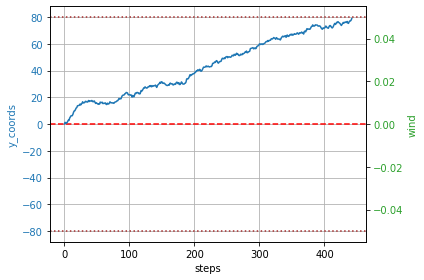

In [56]:
t="[[[4.9975543, 0.15636899], [9.8592615, 1.3241884], [14.833695, 0.8192037], [19.828674, 0.595171], [24.794909, 1.1752751], [29.727482, 1.9936359], [34.634926, 2.9512389], [39.631344, 2.7620728], [44.317303, 4.506144], [49.25715, 5.279411], [54.178043, 6.1653028], [59.17627, 6.298454], [64.17626, 6.289588], [69.06357, 7.345168], [73.81505, 8.901906], [78.72242, 9.859857], [83.72078, 9.988077], [88.59601, 11.098077], [93.51059, 12.01834], [98.49711, 12.3853445], [103.323105, 13.69291], [108.3224, 13.776782], [113.319984, 13.932242], [118.31612, 14.128922], [123.23394, 15.031686], [128.18333, 14.322103], [133.13596, 15.008778], [138.09552, 15.643399], [142.98283, 16.698942], [147.89949, 15.789803], [152.89653, 15.961813], [157.89624, 16.014864], [162.80634, 16.958782], [167.80591, 17.02373], [172.7916, 16.645681], [177.78743, 16.441631], [182.78279, 16.657238], [187.67844, 17.673433], [192.61479, 16.878204], [197.60355, 17.21338], [202.60268, 17.305954], [207.60117, 17.182726], [212.57799, 17.663534], [217.56284, 17.27441], [222.52122, 16.630697], [227.5045, 17.039248], [232.49959, 17.260866], [237.38924, 16.21618], [242.33157, 15.459038], [247.3106, 15.916594], [252.29384, 15.5076685], [257.27606, 15.0862], [262.2677, 14.797471], [267.25256, 15.186374], [272.2473, 14.957599], [277.01498, 16.464079], [281.99976, 16.074312], [286.99976, 16.086403], [291.9912, 16.378468], [296.88986, 15.376867], [301.88834, 15.500197], [306.8877, 15.41933], [311.8777, 15.735306], [316.87686, 15.826573], [321.77145, 14.805415], [326.7688, 14.641905], [331.6689, 15.636249], [336.6488, 15.188242], [341.6454, 15.003473], [346.60486, 15.638898], [351.49493, 16.681515], [356.45303, 16.03549], [361.4507, 15.882841], [366.4484, 16.035093], [371.44073, 15.758759], [376.44073, 15.751631], [381.43604, 15.535144], [386.39374, 16.184143], [391.38092, 16.542305], [396.38016, 16.629276], [401.36966, 16.952944], [406.34363, 17.462404], [411.34354, 17.496397], [416.27692, 18.309738], [421.19223, 19.226152], [426.17596, 18.823112], [431.17426, 18.953228], [436.17426, 18.956717], [440.9834, 20.324982], [445.8929, 21.271883], [450.87903, 21.644526], [455.87888, 21.680555], [460.87302, 21.922655], [465.80554, 22.74131], [470.80417, 22.858969], [475.74173, 23.646593], [480.73877, 23.474052], [485.73593, 23.305658], [490.57285, 22.039108], [495.5683, 21.825462], [500.5649, 22.00909], [505.56415, 21.921576], [510.5564, 21.643124], [515.55615, 21.693644], [520.3141, 20.156733], [525.16815, 21.35583], [530.11194, 20.60832], [535.11005, 20.469099], [539.8684, 22.004656], [544.74225, 23.120573], [549.7349, 22.850182], [554.6878, 23.535004], [559.6864, 23.655012], [564.6835, 23.48449], [569.63654, 22.800808], [574.62976, 23.060144], [579.59985, 22.51369], [584.49976, 23.508984], [589.2211, 25.15476], [594.1946, 24.63975], [599.14856, 25.31643], [604.05927, 26.257227], [608.9917, 27.076483], [613.99023, 26.957539], [618.90796, 27.861057], [623.8769, 27.304428], [628.8656, 26.969168], [633.86536, 26.921015], [638.8307, 27.508839], [643.80676, 27.997578], [648.8059, 27.905912], [653.74805, 28.664316], [658.7179, 28.115774], [663.663, 28.854387], [668.571, 27.899456], [673.5609, 28.21738], [678.53094, 28.763678], [683.52, 28.432755], [688.51733, 28.594772], [693.51245, 28.816559], [698.5, 29.169163], [703.3975, 28.161951], [708.34393, 27.432137], [713.12805, 28.885473], [718.1012, 29.403263], [723.0778, 29.886177], [728.05054, 30.407461], [732.97455, 31.275928], [737.91376, 30.498549], [742.7884, 31.611145], [747.7884, 31.596945], [752.69415, 30.630981], [757.68884, 30.400501], [762.6766, 30.750816], [767.66223, 30.371992], [772.6343, 29.844078], [777.60956, 29.347794], [782.59924, 29.027025], [787.59393, 28.796686], [792.5894, 29.009678], [797.5821, 29.280834], [802.57605, 29.03508], [807.408, 30.320393], [812.39777, 30.640388], [817.3581, 30.011805], [822.35394, 30.21464], [827.35065, 30.031988], [832.296, 29.295002], [837.2958, 29.343302], [842.24506, 30.053574], [847.23395, 29.720327], [852.2329, 29.821192], [857.08026, 31.047237], [862.06995, 31.368786], [867.03955, 30.81838], [871.9988, 30.181368], [876.9369, 30.965942], [881.7503, 29.612906], [886.7503, 29.602573], [891.6838, 30.415636], [896.5506, 31.561909], [901.5003, 30.854586], [906.4235, 29.981657], [911.4232, 29.927355], [916.4231, 29.895206], [921.39124, 30.459042], [926.3891, 30.604013], [931.3158, 31.45701], [935.7937, 33.681557], [940.7823, 34.019524], [945.7774, 33.79965], [950.7437, 34.379505], [955.6402, 35.39165], [960.4306, 36.82414], [965.3794, 36.110577], [970.3228, 36.860504], [975.3226, 36.808754], [980.27277, 37.512646], [985.27264, 37.473225], [990.2589, 37.843678], [995.25885, 37.85355], [1000.1717, 38.783047], [1005.1704, 38.898697], [1010.0767, 39.862026], [1015.0752, 39.739155], [1020.00287, 40.586353], [1024.978, 40.087936], [1029.9764, 40.21382], [1034.9204, 40.959858], [1039.8977, 40.483925], [1044.7977, 39.489197], [1049.7911, 39.747772], [1054.733, 40.507206], [1059.6024, 41.643005], [1064.5076, 42.61221], [1069.506, 42.48819], [1074.505, 42.58492], [1079.4989, 42.832985], [1084.4498, 43.531506], [1089.4036, 42.852375], [1094.4009, 43.013878], [1099.389, 43.358784], [1104.372, 42.945946], [1109.3655, 42.692844], [1114.3605, 42.917896], [1119.359, 43.03628], [1124.359, 43.007793], [1129.3044, 43.744213], [1134.0227, 45.398968], [1139.0225, 45.441223], [1144.013, 45.751278], [1148.9716, 46.39288], [1153.9612, 46.070236], [1158.8778, 46.978954], [1163.8555, 47.451313], [1168.836, 47.010864], [1173.7019, 45.86017], [1178.6948, 45.595715], [1183.6273, 46.41442], [1188.6138, 46.78305], [1193.6138, 46.804897], [1198.61, 46.99938], [1203.3989, 48.4366], [1208.3357, 49.22894], [1213.3337, 49.086567], [1218.3247, 48.787052], [1223.2887, 49.386013], [1228.273, 48.988815], [1233.1481, 50.09903], [1238.1436, 50.31243], [1243.14, 50.49945], [1248.0642, 49.63176], [1253.0374, 50.148685], [1258.0338, 50.336987], [1263.0328, 50.236553], [1268.0231, 49.92449], [1273.0192, 50.122887], [1278.0061, 50.484715], [1282.9099, 51.460224], [1287.9044, 51.223858], [1292.9001, 51.018353], [1297.7771, 52.12075], [1302.7755, 51.995445], [1307.7437, 51.431484], [1312.6316, 52.48389], [1317.6064, 52.98482], [1322.5381, 52.160645], [1327.5349, 52.339058], [1332.4496, 51.41933], [1337.4462, 51.235294], [1342.4435, 51.399334], [1347.3685, 52.26179], [1352.3599, 51.96713], [1357.3574, 51.812115], [1362.2692, 52.74731], [1367.2601, 52.44595], [1372.2422, 52.86849], [1377.2352, 53.132374], [1382.1692, 53.942734], [1387.1685, 53.858833], [1392.1134, 54.598473], [1396.9609, 53.372887], [1401.96, 53.4697], [1406.9302, 54.01504], [1411.9237, 54.269287], [1416.9207, 54.4428], [1421.4965, 56.458324], [1426.495, 56.577553], [1431.4918, 56.75556], [1436.4877, 56.95949], [1441.4832, 57.171326], [1446.4048, 56.289566], [1451.4019, 56.460648], [1456.3755, 56.973537], [1461.3428, 56.402374], [1466.3352, 56.677563], [1471.1608, 57.98677], [1476.1478, 58.346935], [1481.1423, 58.57988], [1486.1283, 58.95394], [1491.0239, 59.97033], [1496.0228, 59.866993], [1501.009, 59.49535], [1505.9968, 59.845406], [1510.9939, 60.01514], [1515.973, 59.55856], [1520.9701, 59.729454], [1525.944, 60.239685], [1530.9407, 60.42146], [1535.92, 60.875298], [1540.8684, 61.592377], [1545.8638, 61.805725], [1550.8619, 61.67091], [1555.7924, 62.502495], [1560.7595, 61.930473], [1565.7073, 62.65128], [1570.7072, 62.6143], [1575.7063, 62.709595], [1580.6102, 63.684704], [1585.6068, 63.86829], [1590.602, 63.649014], [1595.5808, 64.11001], [1600.5441, 64.71507], [1605.5338, 64.395], [1610.5189, 64.01041], [1615.4834, 63.415417], [1620.3315, 64.63849], [1625.3164, 64.25075], [1630.2706, 63.57526], [1635.2699, 63.662006], [1640.2672, 63.498676], [1645.2671, 63.53176], [1650.2263, 62.894424], [1655.158, 63.717957], [1660.033, 64.82928], [1665.0145, 65.2576], [1669.9878, 65.774345], [1674.9622, 65.26869], [1679.9594, 65.435165], [1684.9343, 65.93506], [1689.9341, 65.98518], [1694.8112, 64.88338], [1699.5996, 66.32246], [1704.5945, 66.547775], [1709.4915, 65.53762], [1714.4889, 65.69626], [1719.4797, 65.99816], [1724.3986, 66.89583], [1729.3955, 67.06992], [1734.3751, 66.6184], [1739.3237, 67.332924], [1744.2572, 66.51959], [1749.2554, 66.65422], [1754.2217, 67.23365], [1759.2084, 67.597336], [1764.1907, 67.17671], [1769.1906, 67.20925], [1774.1814, 67.51339], [1779.1372, 68.17605], [1784.1366, 68.09507], [1789.0571, 67.20744], [1794.045, 67.55519], [1798.9836, 68.33615], [1803.9783, 68.10301], [1808.976, 68.25492], [1813.9431, 68.82734], [1818.8877, 68.08567], [1823.8877, 68.1173], [1828.8263, 67.336365], [1833.428, 69.29197], [1838.4232, 69.50991], [1843.3911, 68.94397], [1848.288, 69.95443], [1853.0977, 71.320625], [1858.0663, 70.76117], [1863.0596, 71.01928], [1868.0586, 71.118866], [1873.0521, 70.863396], [1878.0483, 71.05705], [1882.9672, 71.95433], [1887.8632, 72.96885], [1892.8595, 73.16068], [1897.7567, 74.16887], [1902.6797, 73.29427], [1907.6797, 73.296455], [1912.6788, 73.38965], [1917.6112, 74.20904], [1922.6096, 74.08439], [1927.6096, 74.05375], [1932.6096, 74.04585], [1937.5613, 73.35254], [1942.5603, 73.255165], [1947.5557, 73.46954], [1952.5542, 73.348145], [1957.5167, 72.73722], [1962.4406, 71.867424], [1967.393, 71.17879], [1972.3878, 70.953285], [1977.2826, 71.97387], [1982.2778, 71.75697], [1987.2778, 71.77239], [1992.2506, 72.293434], [1997.1487, 73.29781], [2002.1361, 72.94371], [2007.0668, 72.11425], [2012.0613, 71.87808], [2017.0562, 71.653336], [2021.9258, 72.78783], [2026.8593, 73.6008], [2031.8584, 73.69109], [2036.8235, 73.10109], [2041.7474, 72.23231], [2046.7365, 71.90113], [2051.708, 72.433205], [2056.6174, 73.38053], [2061.4673, 74.596924], [2066.4177, 75.29893], [2071.3503, 74.48111], [2076.2922, 75.24161], [2081.2092, 76.14918], [2086.2026, 75.89357], [2091.1592, 76.552345], [2096.123, 75.95405], [2101.1135, 75.642136], [2106.0916, 75.175224], [2111.0466, 74.50722], [2115.985, 73.724205], [2120.9324, 74.448105], [2125.8875, 75.11762], [2130.803, 76.03264], [2135.7832, 75.59018], [2140.7732, 75.90651], [2145.748, 76.40878], [2150.7341, 76.0376], [2155.734, 75.98632], [2160.6792, 76.72463], [2165.5334, 75.5262], [2170.5286, 75.30806], [2175.389, 76.481415], [2180.3486, 77.11544], [2185.3486, 77.09859], [2190.3147, 77.68075], [2195.1685, 78.88089], [2200.0745, 79.84534]]]"
d="[[[0]]]"
combine_distri_trajectory(json.loads(t),json.loads(d))